In [ ]:
# Importing library to upload files
from google.colab import files
!pip install -U kaggle

# Uploading the API token
upload = files.upload()

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


Saving kaggle.json to kaggle.json


In [ ]:
# Make a directory named 'kaggle' in root folder. This will let you know if 
# any directory is already present
!mkdir ~/.kaggle 

# Copy the jason file there. This should also give you an user access warning
!cp kaggle.json ~/.kaggle/

# Change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download the data through kaggle API
!kaggle competitions download -c m5-forecasting-accuracy

  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 63.6MB/s]
 63% 9.00M/14.2M [00:00<00:00, 20.2MB/s]
100% 14.2M/14.2M [00:00<00:00, 28.9MB/s]
 57% 9.00M/15.8M [00:01<00:00, 7.85MB/s]
100% 15.8M/15.8M [00:01<00:00, 14.9MB/s]
 58% 9.00M/15.5M [00:00<00:00, 25.1MB/s]
100% 15.5M/15.5M [00:00<00:00, 39.3MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 108MB/s]


In [ ]:
!unzip sales_train_evaluation.csv.zip
!unzip sell_prices.csv.zip

Archive:  sales_train_evaluation.csv.zip
  inflating: sales_train_evaluation.csv  
Archive:  sell_prices.csv.zip
  inflating: sell_prices.csv         


## Dataset:

The data was provided by Kaggle website: M5 Forecasting - Accuracy, Estimate the unit
sales of Walmart retail goods. The data covers stores in three US States (California, Texas, and
Wisconsin) and includes item level, department, product categories, and store details. In
addition, it has explanatory variables such as price, promotions, day of the week, and special
events. Together, this robust dataset can be used to improve forecasting accuracy.

## Objective:

We would like to provide a consistent model to predict the Walmart sales of each product
for the next 28 days window based on the previous sales history. We will take the internal
factors, which are the sales on each day, and the external factor, which are the date, special
events and price of the product.

Start with EDA

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings generated in the notebook
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Reading three main datasets to dataframes
sales_train = pd.read_csv('/content/sales_train_evaluation.csv')
sell_prices = pd.read_csv('/content/sell_prices.csv')
calendar = pd.read_csv('/content/calendar.csv')

* Sales Train data contains the historical daily unit sales data per product and store from
2011/01/29 to 2016/06/14, which is 1913 days. 
* The products are distributed in 3
categories: 'Hobbies', 'Household', 'Foods', and the department id only varies on the
sequential numbers

In [ ]:
# Printing top 10 rows of sales_train to get feel of the data
sales_train.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,2,0,0,0,0,1,0,0,2,4,1,0,0,0,2,1,0,0,3,0,5,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,0,4,6,5,7,0,13,2,2,20,9,3,0,1,0,0,0,10,4,4,2,6,2,0,0,0,0,0,0,0,...,8,4,0,0,1,37,3,4,6,3,2,1,19,3,2,8,8,23,26,9,4,8,5,8,5,0,3,1,18,47,7,0,6,0,15,5,4,1,40,32
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,0,2,3,9,0,0,4,3,1,0,4,4,1,2,0,1,1,5,2,2,2,3,0,0,8,0,0,0,0,0,...,0,0,0,0,1,1,6,0,0,0,0,0,0,2,6,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2,0,2,0,2,1,0,0,0,0,0,0,0,0,2,0,2,1,0,0,1,0,0,1,0,2,1,1,0,0,1


In [ ]:
# Checking shape of the dataset
sales_train.shape

(30490, 1947)

In [ ]:
# Checking number of unique values in each of the variables
print(
'''
Total amount of id: {5}
Unique:
state_id: {0}
store_id: {1}
dept_id:  {2}
cat_id:{3}
item_id:{4}
'''.format(
    sales_train.state_id.nunique(),
    sales_train.store_id.nunique(),
    sales_train.dept_id.nunique(),
    sales_train.cat_id.nunique(),
    sales_train.item_id.nunique(),
    len(sales_train)
    )
    )



Total amount of id: 30490
Unique:
state_id: 3
store_id: 10
dept_id:  7
cat_id:3
item_id:3049



* So there are 3 states, 10 stores, in each stores there are 7 departments, and in each departments there are 3 categories, and total of 3049 unique items

In [ ]:
# null values check
sales_train.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [ ]:
# datatypes of each variables
sales_train.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1937       int64
d_1938       int64
d_1939       int64
d_1940       int64
d_1941       int64
Length: 1947, dtype: object

In [ ]:
# value counts of each variable
for i in sales_train.columns[1:6]:
  print(sales_train[i].value_counts())
  print('*'*50)

HOUSEHOLD_2_099    10
HOUSEHOLD_2_184    10
HOUSEHOLD_1_508    10
HOUSEHOLD_1_511    10
FOODS_3_469        10
                   ..
FOODS_3_181        10
HOUSEHOLD_2_359    10
HOUSEHOLD_2_219    10
FOODS_3_075        10
HOUSEHOLD_2_353    10
Name: item_id, Length: 3049, dtype: int64
**************************************************
FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64
**************************************************
FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64
**************************************************
CA_2    3049
TX_3    3049
WI_3    3049
CA_3    3049
CA_4    3049
TX_2    3049
WI_2    3049
CA_1    3049
TX_1    3049
WI_1    3049
Name: store_id, dtype: int64
**************************************************
CA    12196
WI     9147
TX     9147
Name: state_id, dtype: int64
************************************

In [ ]:
# statistical description of numerical columns in the datset
sales_train.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,0.756674,0.775927,0.779141,0.867334,1.142440,1.193178,0.715120,0.789439,0.703280,0.666382,0.777993,1.039324,0.960413,0.786028,0.672384,0.680781,0.665038,0.738898,0.980912,0.941522,0.696622,0.750148,0.723057,0.769925,0.773106,1.023352,1.143850,0.805576,0.746212,0.739915,...,1.154247,1.230863,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158,1.272319,1.163890,1.129715,1.139128,1.406888,1.653952,1.739324,1.416235,1.453395,1.298819,1.336930,1.436701,1.778911,1.495867,1.521810,1.291538,1.385635,1.328403,1.445490,1.781174,1.965267,1.389374,1.271794,1.216661,1.212299,1.395605,1.689669,1.782158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,3.665969,3.697822,3.486595,3.484608,4.636395,4.662770,2.993414,3.296922,2.811648,2.611911,2.985123,3.923110,3.597620,3.084773,2.874189,2.727852,2.637849,2.842334,3.714944,3.688771,2.708641,2.922533,2.888537,3.085799,3.136922,3.944627,4.617819,3.076988,3.011551,3.023168,...,2.933918,3.303282,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248,3.237593,2.958058,2.899251,2.884903,3.601825,4.078230,4.012232,3.448094,3.629592,3.312139,3.370512,3.862338,4.529591,3.949142,3.854184,3.189395,3.557375,3.316416,3.656824,4.426550,4.706284,3.313292,3.126178,3.000348,2.955910,3.514318,4.089208,4.284356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

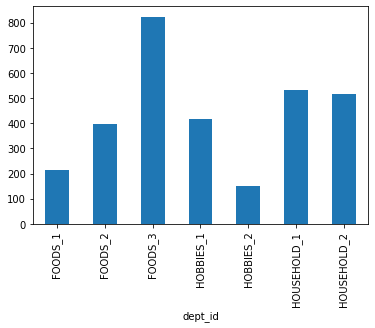

In [ ]:
sales_train.groupby('dept_id')['item_id'].nunique().plot(kind='bar')

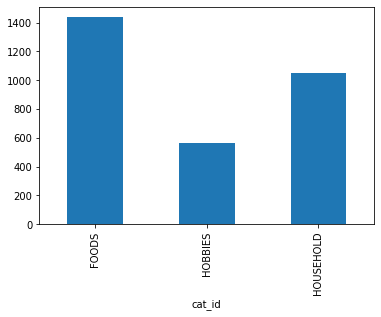

In [ ]:
sales_train.groupby('cat_id')['item_id'].nunique().plot(kind='bar')

In [ ]:
# State wise daily sales
state_wise = sales_train.groupby('state_id').sum().T
state_wise

state_id,CA,TX,WI
d_1,14195,9438,8998
d_2,13805,9630,8314
d_3,10108,6778,6897
d_4,11047,7381,6984
d_5,9925,5912,3309
...,...,...,...
d_1937,15678,10375,11043
d_1938,16297,9162,11504
d_1939,17430,12303,12819
d_1940,23103,13681,14734


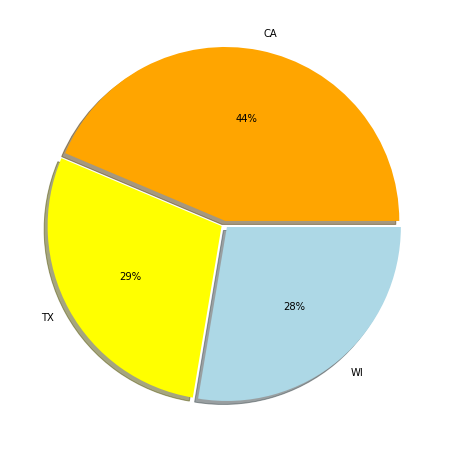

In [ ]:
plt.figure(figsize=(8,8))
# plt.pie(state_cal[['CA','TX','WI']].sum(),explode=[0.01,0.01,0.01],autopct='%1.0f%%',colors=['gray','yellow','green'],labels=['CA','TX','WI']);
plt.pie(state_wise.sum(),explode=[0.02,0.02,0.02],autopct='%1.0f%%',colors=['orange','yellow','lightblue'],labels=['CA','TX','WI'], shadow=True);

* We can see that CA has the highest sales followed by TX and WI

In [ ]:
# Store wise daily sale count
store_wise = sales_train.groupby('store_id').sum().T
store_wise

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...
d_1937,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268
d_1938,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398
d_1939,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126
d_1940,5764,7120,7073,3146,4167,4802,4712,5002,5213,4519


In [ ]:
# there are three categories in each store, will check daily sale count of each category
category_wise = sales_train.groupby(['cat_id']).sum().T
category_wise

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,23178,3764,5689
d_2,22758,3357,5634
d_3,17174,2682,3927
d_4,18878,2669,3865
d_5,14603,1814,2729
...,...,...,...
d_1937,24790,3740,8566
d_1938,24737,3475,8751
d_1939,28136,4143,10273
d_1940,33599,5333,12586


In [ ]:
# daily product sales count in each department
department_wise = sales_train.groupby(['dept_id']).sum().T
department_wise

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
d_1,2343,4094,16741,3610,154,4105,1584
d_2,2216,4209,16333,3172,185,3858,1776
d_3,1657,3174,12343,2497,185,2827,1100
d_4,1508,3606,13764,2531,138,2732,1133
d_5,1209,2869,10525,1714,100,1802,927
...,...,...,...,...,...,...,...
d_1937,3073,4648,17069,3291,449,6641,1925
d_1938,3251,4551,16935,3027,448,6759,1992
d_1939,3735,4815,19586,3761,382,7974,2299
d_1940,4195,5940,23464,4832,501,9668,2918


In [ ]:
# there are 3049 unique items
unique_items = sales_train.groupby(['item_id']).sum().T
unique_items

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,FOODS_1_012,FOODS_1_013,FOODS_1_014,FOODS_1_015,FOODS_1_016,FOODS_1_017,FOODS_1_018,FOODS_1_019,FOODS_1_020,FOODS_1_021,FOODS_1_022,FOODS_1_023,FOODS_1_024,FOODS_1_025,FOODS_1_026,FOODS_1_027,FOODS_1_028,FOODS_1_029,FOODS_1_030,FOODS_1_031,FOODS_1_032,FOODS_1_033,FOODS_1_034,FOODS_1_035,FOODS_1_036,FOODS_1_037,FOODS_1_038,FOODS_1_039,FOODS_1_040,FOODS_1_041,...,HOUSEHOLD_2_477,HOUSEHOLD_2_478,HOUSEHOLD_2_479,HOUSEHOLD_2_480,HOUSEHOLD_2_481,HOUSEHOLD_2_482,HOUSEHOLD_2_483,HOUSEHOLD_2_484,HOUSEHOLD_2_485,HOUSEHOLD_2_486,HOUSEHOLD_2_487,HOUSEHOLD_2_488,HOUSEHOLD_2_489,HOUSEHOLD_2_490,HOUSEHOLD_2_491,HOUSEHOLD_2_492,HOUSEHOLD_2_493,HOUSEHOLD_2_494,HOUSEHOLD_2_495,HOUSEHOLD_2_496,HOUSEHOLD_2_497,HOUSEHOLD_2_498,HOUSEHOLD_2_499,HOUSEHOLD_2_500,HOUSEHOLD_2_501,HOUSEHOLD_2_502,HOUSEHOLD_2_503,HOUSEHOLD_2_504,HOUSEHOLD_2_505,HOUSEHOLD_2_506,HOUSEHOLD_2_507,HOUSEHOLD_2_508,HOUSEHOLD_2_509,HOUSEHOLD_2_510,HOUSEHOLD_2_511,HOUSEHOLD_2_512,HOUSEHOLD_2_513,HOUSEHOLD_2_514,HOUSEHOLD_2_515,HOUSEHOLD_2_516
d_1,6,4,14,0,34,16,0,0,0,7,0,8,0,0,13,0,47,106,14,0,0,0,30,0,6,0,0,0,2,22,62,0,0,7,33,5,0,0,23,16,...,0,0,0,4,3,0,7,0,5,6,0,4,0,0,0,6,0,2,13,0,8,0,0,0,0,1,1,0,0,0,0,0,8,0,20,5,0,4,0,2
d_2,6,5,8,0,32,9,0,0,0,1,0,9,0,0,5,0,26,104,22,0,0,0,28,0,7,0,0,0,0,21,63,0,0,12,23,4,0,0,38,17,...,0,0,0,2,3,0,13,0,5,4,0,6,0,0,0,15,0,3,10,0,6,0,0,0,0,1,4,0,0,0,0,0,10,0,24,4,0,8,0,4
d_3,4,7,3,0,13,20,0,0,0,5,0,20,0,0,0,0,30,47,21,0,0,0,22,0,7,0,0,0,1,14,34,0,0,8,13,1,0,0,17,13,...,0,0,0,1,1,0,12,0,4,1,0,1,0,0,0,4,0,2,10,0,6,0,0,0,0,0,2,0,0,0,0,0,12,0,7,1,0,2,0,0
d_4,6,4,6,0,20,16,0,0,0,1,0,8,0,0,1,0,24,69,12,0,0,0,26,0,14,0,0,0,1,6,54,0,0,0,27,2,0,0,9,14,...,0,0,0,2,4,0,9,0,1,2,0,5,0,0,0,10,0,0,11,0,5,0,0,0,0,0,2,0,0,0,0,0,8,0,7,3,0,1,0,3
d_5,7,3,3,0,10,14,0,0,0,0,0,14,0,0,7,0,13,51,6,0,0,0,15,0,5,0,0,0,1,13,48,0,0,1,26,1,0,0,8,6,...,0,0,0,4,2,0,9,0,0,4,0,1,0,0,0,0,0,0,5,0,4,0,0,0,0,1,1,0,0,0,0,0,9,0,9,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,7,5,7,62,25,13,3,2,2,3,36,8,12,8,6,13,71,39,13,4,2,30,8,3,4,15,5,1,7,20,52,1,2,11,13,19,7,4,7,9,...,8,1,2,2,2,1,10,4,3,3,1,8,1,16,4,7,1,0,2,5,1,3,18,5,5,2,0,6,2,2,6,1,7,6,10,3,3,0,2,1
d_1938,5,0,7,71,19,9,2,7,4,8,53,9,23,4,9,16,99,62,13,5,6,36,5,11,17,19,16,1,3,10,75,1,8,11,12,13,13,5,13,9,...,8,0,0,2,1,1,16,3,3,4,1,2,1,9,0,3,4,2,6,3,6,4,14,1,4,0,0,1,3,2,4,0,3,10,9,4,0,1,3,1
d_1939,7,6,10,75,25,9,1,10,9,5,57,4,18,14,8,12,100,73,17,9,6,35,14,5,5,23,11,4,7,15,72,0,9,9,16,12,4,4,10,5,...,11,1,2,1,0,2,15,3,4,3,1,6,2,14,0,5,8,4,12,4,4,4,19,2,2,4,1,0,1,3,11,0,6,9,9,5,9,4,0,3
d_1940,5,6,6,83,17,11,0,10,6,16,61,20,13,22,8,10,128,92,12,12,3,29,17,7,9,41,17,3,6,14,89,4,9,12,23,17,10,1,10,14,...,18,1,4,0,2,5,18,3,6,6,2,6,1,15,6,13,8,2,8,5,3,8,16,2,4,3,0,6,3,2,12,1,3,13,8,4,3,3,3,4


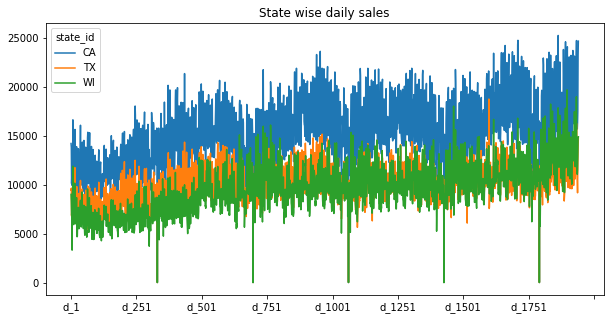

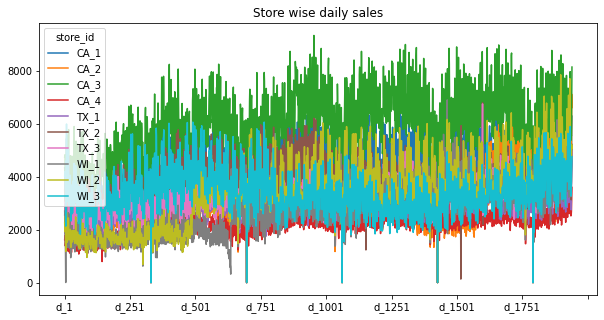

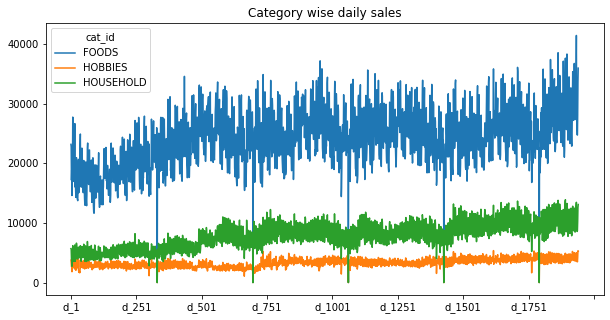

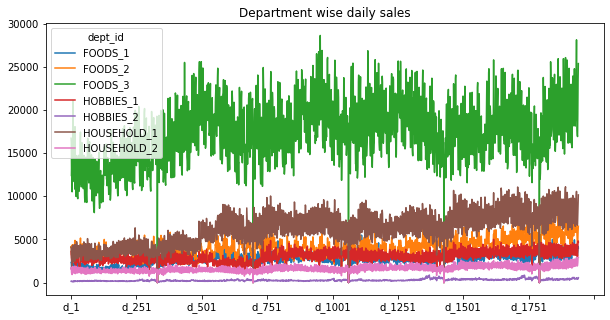

In [ ]:
#Plots to see the distribution of the features individually

# plt.subplot(2,2,1)
state_wise.plot(figsize= (10,5))
# plt.plot(state_wise)
plt.title('State wise daily sales')
plt.show()

# plt.subplot(2,2,2)
store_wise.plot(figsize= (10,5))
# plt.plot(store_wise)
plt.title('Store wise daily sales')
plt.show()

# plt.subplot(2,2,1)
category_wise.plot(figsize= (10,5))
# plt.plot(category_wise)
plt.title('Category wise daily sales')
plt.show()

# plt.subplot(2,2,2)
department_wise.plot(figsize= (10,5))
plt.title('Department wise daily sales')
plt.show()


Observations:-

* California(CA) has the highest sales compared to WI and TX

* One store called CA_3 has more sales compared to other 9 stores

* We can see that Food Category has highest sales compared to other two catefories

* In Food also, there is one deparment that is FOODS_1 which has more sale counts than any other

In [ ]:
# Sales counts of each category in CA State
CA_cat = sales_train[sales_train.state_id=='CA'].groupby(['cat_id']).sum().T
CA_cat

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_1,10101,1802,2292
d_2,9862,1561,2382
d_3,6944,1472,1692
d_4,7864,1405,1778
d_5,7178,1181,1566
...,...,...,...
d_1937,10465,1606,3607
d_1938,10650,1735,3912
d_1939,11354,1975,4101
d_1940,14489,2701,5913


* Numbers tells that Food category has the highest sales, off course, Food is the important factor to survive, hence it has  more sales in every state and stores as well

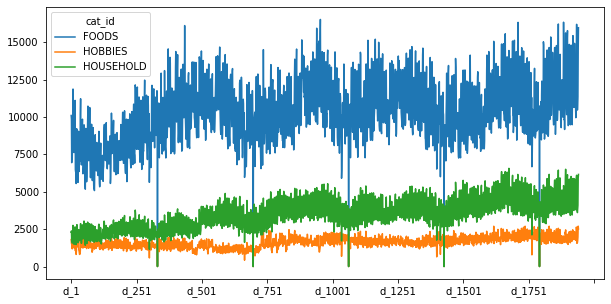

In [ ]:
CA_cat.plot(figsize=(10,5))

* Calendar dataset Contains information about the dates on which the products are sold and
special events information, like national vacations and religious memorial days.

In [ ]:
# Calendar data anaysis
calendar.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [ ]:
calendar.shape

(1969, 14)

In [ ]:
calendar.fillna(0, inplace=True)

In [ ]:
calendar.event_type_1.unique(), calendar.event_name_1.unique(), calendar.event_type_2.unique(), calendar.event_name_2.unique()

(array([0, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object),
 array([0, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
        'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
        'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
        'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
        'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
        'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
        'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
        'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object),
 array([0, 'Cultural', 'Religious'], dtype=object),
 array([0, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"],
       dtype=object))

In [ ]:
calendar.event_type_1.nunique(), calendar.event_name_1.nunique(), calendar.event_type_2.nunique(), calendar.event_name_2.nunique()

(5, 31, 3, 5)

In [ ]:
pd.crosstab(calendar['event_type_1'],calendar['event_name_1'])

event_name_1,0,Chanukah End,Christmas,Cinco De Mayo,ColumbusDay,Easter,Eid al-Fitr,EidAlAdha,Father's day,Halloween,IndependenceDay,LaborDay,LentStart,LentWeek2,MartinLutherKingDay,MemorialDay,Mother's day,NBAFinalsEnd,NBAFinalsStart,NewYear,OrthodoxChristmas,OrthodoxEaster,Pesach End,PresidentsDay,Purim End,Ramadan starts,StPatricksDay,SuperBowl,Thanksgiving,ValentinesDay,VeteransDay
event_type_1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1807,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cultural,0,0,0,5,0,5,0,0,4,5,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,6,0,0,6,0
National,0,0,5,0,5,0,0,0,0,0,5,5,0,0,5,6,0,0,0,5,0,0,0,6,0,0,0,0,5,0,5
Religious,0,5,0,0,0,0,5,5,0,0,0,0,6,6,0,0,0,0,0,0,5,5,6,0,6,6,0,0,0,0,0
Sporting,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0,0,0,0,0,0,0,0,6,0,0,0


In [ ]:
# Joining filtered dataset and calendar on daily sales and Setting the index to date column
state_cal = calendar[0:1941].join(state_wise,on='d').set_index('date')
state_cal

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI
date,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0,14195,9438,8998
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0,13805,9630,8314
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,0,0,0,0,10108,6778,6897
2011-02-01,11101,Tuesday,4,2,2011,d_4,0,0,0,0,1,1,0,11047,7381,6984
2011-02-02,11101,Wednesday,5,2,2011,d_5,0,0,0,0,1,0,1,9925,5912,3309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,Wednesday,5,5,2016,d_1937,0,0,0,0,0,0,0,15678,10375,11043
2016-05-19,11616,Thursday,6,5,2016,d_1938,0,0,0,0,0,0,0,16297,9162,11504
2016-05-20,11616,Friday,7,5,2016,d_1939,0,0,0,0,0,0,0,17430,12303,12819


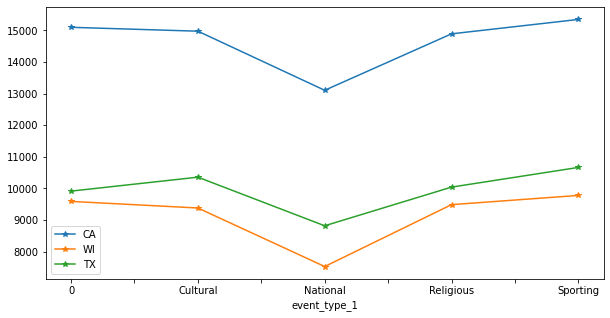

In [ ]:
state_cal.groupby('event_type_1')[['CA','WI','TX']].mean().plot(figsize = (10,5),marker = '*')

* We can see that on National events sales tends to go down because of Holidays on those days and on sporting and Cultural days sales goes high in every state

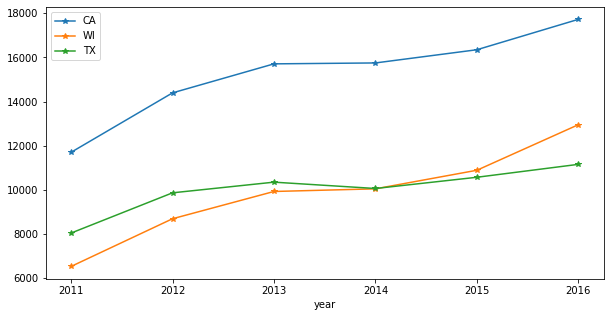

In [ ]:
state_cal.groupby('year')[['CA','WI','TX']].mean().plot(figsize = (10,5),marker = '*')

* Every year, sale of goods in upwards trend

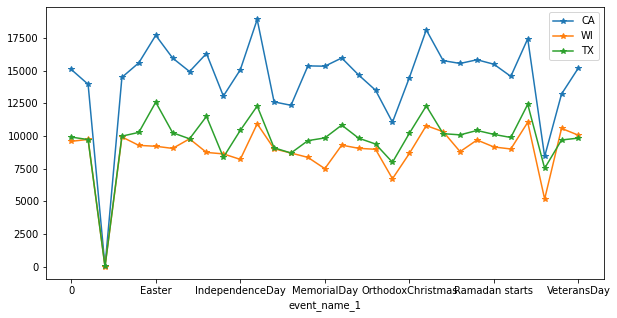

In [ ]:
state_cal.groupby('event_name_1')[['CA','WI','TX']].mean().plot(figsize = (10,5),marker = '*')

* Labor day has the more sale average and Chanukah event has the less sale average

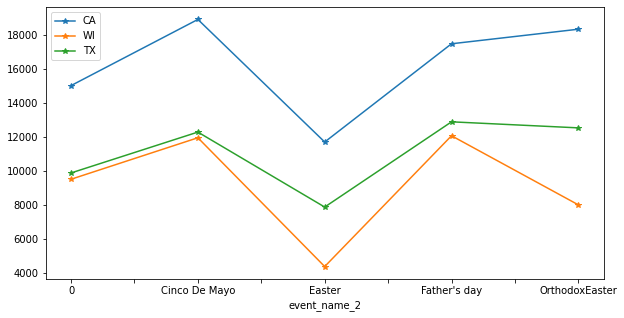

In [ ]:
state_cal.groupby('event_name_2')[['CA','WI','TX']].mean().plot(figsize = (10,5),marker = '*')

In [ ]:
state_cal.index = pd.to_datetime(state_cal.index)

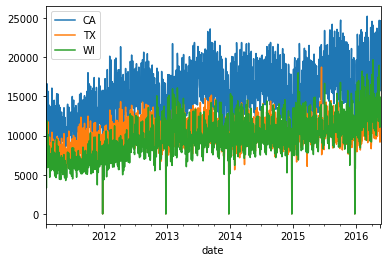

In [ ]:
state_cal[['CA','TX','WI']].plot()

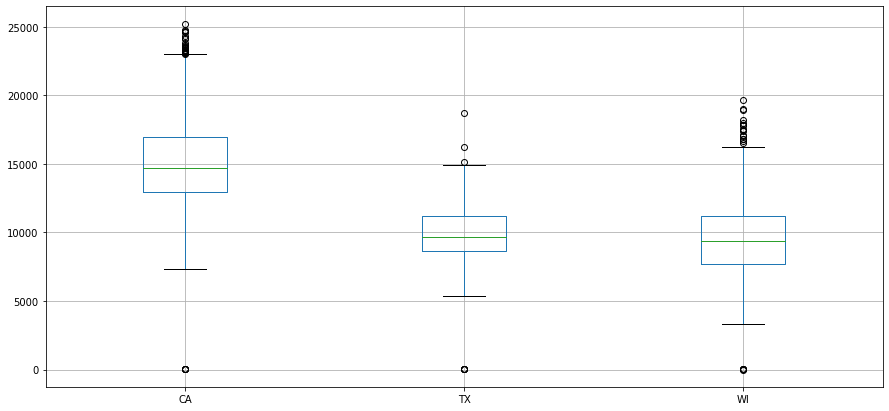

In [ ]:
state_cal[['CA','TX','WI']].boxplot(figsize=(15,7))

* CA's average sales are more than any other states in the dataset

In [ ]:
# Let's check the sell_prices dataset
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [ ]:
# Average sell_price of each store
weekly_sell_prices = sell_prices.groupby(['store_id'])['sell_price'].mean()
weekly_sell_prices

store_id
CA_1    4.414233
CA_2    4.445500
CA_3    4.388229
CA_4    4.421580
TX_1    4.374569
TX_2    4.366766
TX_3    4.387365
WI_1    4.457712
WI_2    4.441717
WI_3    4.418117
Name: sell_price, dtype: float64

In [ ]:
stores = sales_train.groupby('store_id').sum().T
stores

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...
d_1937,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268
d_1938,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398
d_1939,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126
d_1940,5764,7120,7073,3146,4167,4802,4712,5002,5213,4519


In [ ]:
state_store_cal = state_cal.join(stores,on='d')
state_store_cal

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,0,0,0,0,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
2011-02-01,11101,Tuesday,4,2,2011,d_4,0,0,0,0,1,1,0,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
2011-02-02,11101,Wednesday,5,2,2011,d_5,0,0,0,0,1,0,1,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,Wednesday,5,5,2016,d_1937,0,0,0,0,0,0,0,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268
2016-05-19,11616,Thursday,6,5,2016,d_1938,0,0,0,0,0,0,0,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398
2016-05-20,11616,Friday,7,5,2016,d_1939,0,0,0,0,0,0,0,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126


In [ ]:
group = sales_train.groupby('store_id').sum().reset_index()
group = group.join(weekly_sell_prices,on='store_id')
group.set_index('store_id',inplace=True)
group

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,sell_price
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,4354,2757,2430,2272,2009,3015,4553,3966,3264,2441,2377,2414,2701,3719,3548,2246,2549,2559,2568,2978,4096,4832,3138,2997,2772,...,3637,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113,4472,3703,3715,3618,4573,5898,6397,4794,4594,4234,3918,4804,6069,5212,4859,4104,3982,4049,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289,4.414233
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,2123,1901,2436,2584,3455,3563,1801,1797,1741,1614,2214,3080,3087,2601,1810,1851,1652,2187,3516,2692,1894,1958,1837,2010,2105,3199,3272,1970,1800,2064,...,3441,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082,3926,3525,3527,3754,4382,6349,6193,4434,3977,4243,4020,4492,6636,5330,3999,4092,3722,3751,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614,4.445500
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,4447,4544,4406,4380,5187,5780,3303,3758,3641,3099,3320,4694,4794,4631,3593,3342,3310,3575,4774,4540,3604,3846,3821,3757,3904,4894,5895,4274,4084,3754,...,5493,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721,6359,5289,5065,5015,5705,7057,7828,6776,6325,6204,5793,5842,7346,6743,6958,5960,5884,5039,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144,4.388229
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,1368,1195,1434,1312,1652,1933,1183,1511,1190,1113,1476,1543,1618,1501,1286,1371,1138,1384,1643,1711,1452,1429,1320,1375,1457,1595,2058,1571,1418,1361,...,2498,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271,2767,2495,2529,2277,2520,3023,3271,3113,2934,2585,2466,2500,3068,2675,3100,2815,2603,2659,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597,4.421580
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,1607,2149,1895,2256,2944,3432,1921,2217,1962,1821,1951,2571,2810,2071,1933,1723,1825,1886,2629,2688,1985,1967,1860,2052,1753,2642,3031,2272,1788,2180,...,2924,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033,3076,2853,2984,2664,3687,4052,4412,2859,3217,2839,3170,3428,4123,3196,3437,3020,3398,3351,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624,4.374569
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,2628,2669,2515,2883,4000,4779,2679,2927,2606,2449,2615,3705,3845,3006,2725,2268,2488,2506,3565,3660,2548,3023,2383,2545,2718,3627,4379,2954,2495,2705,...,3851,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292,3883,3502,3256,3441,4023,4508,4872,3831,4088,3612,3708,4290,4619,4035,4172,3696,3899,4019,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217,4.366766
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,1989,1922,1699,2063,3137,3514,2119,2316,2038,2142,2145,2874,3134,2220,1970,1823,1862,1894,2392,2738,2022,2092,1902,2042,2113,2969,3013,2397,2052,2056,...,3517,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957,3703,3578,3335,3550,4452,4134,4909,4029,4644,3458,3955,4055,4926,4154,4426,3864,4017,4121,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974,4.387365
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,1335,1410,1349,1946,2634,2012,1522,1363,1300,1459,1872,2596,1415,939,1089,1413,1449,1830,2154,1784,1327,1352,1279,1338,1560,1867,1996,1453,1359,1157,...,3241,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874,3166,3194,3267,3201,4143,5318,5228,3502,3456,3444,3730,4142,5432,4059,3895,3227,3948,3682,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054,4.457712
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,1526,1846,1785,2015,2442,2336,1612,1980,1628,1678,1813,2014,1592,1356,1330,

No handles with labels found to put in legend.


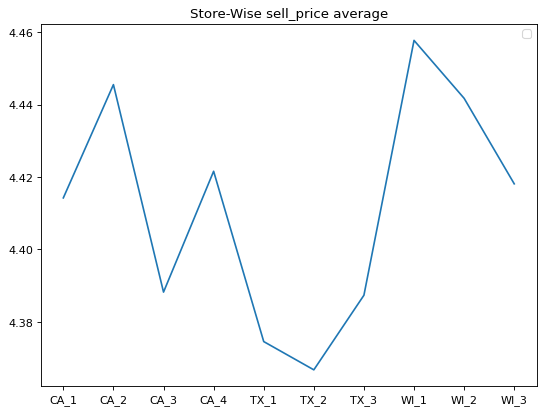

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(group['sell_price'])
plt.legend()
plt.title('Store-Wise sell_price average')
plt.show()

In [ ]:
# grouping the dataset on each variable: state_id, store_id, cat_id
grouped = sales_train.groupby(['store_id','cat_id','state_id'], as_index=False).sum().dropna()
grouped

,store_id,cat_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1,FOODS,CA,3239,3137,2008,2258,2032,2407,2693,3962,3418,2446,2138,2001,2137,2217,3067,3313,2003,1779,1670,1433,2250,3148,2864,2105,1621,1608,1639,1875,2574,2733,1732,1896,1965,1984,2369,3223,3464,...,2341,2421,2706,3481,4004,2886,2488,2490,2533,2960,3655,4053,2893,2518,2467,2446,3032,3950,4254,3278,2997,2840,2735,3303,4106,3630,3245,2896,2687,2663,3365,4046,4717,3198,2794,2816,2854,2993,3783,4327
1,CA_1,HOBBIES,CA,556,498,415,392,268,467,346,769,432,384,496,399,454,453,692,458,379,334,270,280,311,793,501,626,455,418,426,403,613,215,178,230,197,168,193,300,761,...,415,429,401,722,655,542,495,363,410,527,670,714,589,426,451,432,584,636,684,529,628,565,439,570,646,513,641,389,505,596,588,806,687,417,393,381,406,539,719,646
2,CA_1,HOUSEHOLD,CA,542,520,393,401,330,402,411,706,490,327,361,310,337,408,557,583,375,317,332,296,454,612,601,533,365,351,349,423,532,600,336,423,397,416,416,573,607,...,722,787,875,1234,1295,917,810,869,766,900,1252,1346,990,759,797,740,957,1312,1459,987,969,829,744,931,1317,1069,973,819,790,790,998,1393,1303,953,762,798,876,901,1262,1316
3,CA_2,FOODS,CA,2193,1921,1289,1540,1278,1494,1785,2385,1827,1355,1383,1191,1658,1603,2039,2106,1132,1067,1078,1071,1463,1717,1779,1476,1134,1098,1019,1377,2070,1744,1097,1317,1242,1341,1387,2119,2013,...,2264,2200,2891,3423,3729,2625,2410,2506,2261,2871,3760,4012,2654,2306,2224,2457,2861,4041,4017,2995,2624,3015,2649,2985,4297,3458,2730,2680,2506,2491,3255,3972,4285,2902,2649,2561,2725,3179,4502,4198
4,CA_2,HOBBIES,CA,538,397,368,350,296,391,316,413,452,403,284,314,304,371,541,591,271,257,213,144,255,569,417,405,258,302,262,344,678,250,347,232,196,159,190,282,388,...,343,374,483,486,483,320,368,344,271,485,542,507,361,336,360,400,438,594,579,360,377,350,432,471,582,538,353,466,342,315,370,687,588,326,385,334,357,434,762,660
5,CA_2,HOUSEHOLD,CA,763,728,464,434,368,403,528,931,678,460,456,396,474,610,875,866,398,473,450,399,496,794,891,720,418,451,371,466,768,698,450,409,399,510,528,798,871,...,938,867,1066,1443,1548,885,853,841,771,1101,1582,1563,911,883,943,897,1083,1714,1597,1079,976,878,939,1036,1757,1334,916,946,874,945,1214,1848,1837,1010,929,894,955,1138,1856,1756
6,CA_3,FOODS,CA,3446,3535,2701,3064,2761,3340,3455,4068,4324,3718,3473,3589,3355,3225,3850,4276,2459,2514,2677,2212,2413,3240,3331,3106,2263,2285,2168,2430,3303,3233,2513,2870,2795,2823,2939,3708,4293,...,3403,3344,3471,4307,5127,3827,3468,3286,3056,3409,4459,4698,4106,3182,3234,3115,3503,4315,4878,4158,3883,4113,3623,3643,4509,4327,4583,3875,3615,3115,3864,4311,4980,3685,3491,3425,3456,3497,4315,5069
7,CA_3,HOBBIES,CA,550,430,438,424,364,390,493,525,375,478,401,365,390,403,465,581,252,458,272,265,259,465,440,531,524,349,449,407,539,363,278,279,263,255,281,279,518,...,505,558,432,635,848,467,588,534,540,598,765,670,559,636,479,536,556,707,773,643,661,574,566,496,730,584,585,537,553,436,502,665,713,482,532,565,596,571,675,754
8,CA_3,HOUSEHOLD,CA,743,862,646,744,692,639,755,863,882,716,573,590,661,752,872,923,592,786,692,622,648,989,1023,994,806,708,693,738,932,944,813,697,763,679,684,907,1084,...,1469,1591,1434,1994,2296,1774,1627,1415,1422,1616,2195,2353,1694,1471,1352,1364,1646,2035,2177,1975,1781,1517,1604,1703,2107,1832,1790,1548,1716,1488,1680,2053,2276,1724,1500,1385,1528,1474,2083,2321
9,CA_4,FOODS,CA,1223,1269,946,1002,1107,1015,1072,1455,1408,1118,967,844,997,947,1173,1414,889,976,841,834,1062,1108,1113,1075,947,860,799,995,1096,1214,1011,1006,998,962,1069,1129,1451,...,1415,1541,1664,1883,1995,1879,1722,1581,1629,1751

In [ ]:
# Melting the dataset on each variable: store_id, cat_id, state_id
sales = pd.melt(grouped, id_vars=['store_id','cat_id','state_id'], var_name='d', value_name='sold').dropna()

1941(no.of days) * 3(no.of states) * 10(no.of stores) = 58230 datapoints

In [ ]:
sales

,store_id,cat_id,state_id,d,sold
0,CA_1,FOODS,CA,d_1,3239
1,CA_1,HOBBIES,CA,d_1,556
2,CA_1,HOUSEHOLD,CA,d_1,542
3,CA_2,FOODS,CA,d_1,2193
4,CA_2,HOBBIES,CA,d_1,538
...,...,...,...,...,...
58225,WI_2,HOBBIES,WI,d_1941,281
58226,WI_2,HOUSEHOLD,WI,d_1941,1230
58227,WI_3,FOODS,WI,d_1941,3484
58228,WI_3,HOBBIES,WI,d_1941,342


In [ ]:
df = pd.merge(sales, calendar,how = "left",on = 'd')
df

,store_id,cat_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1,FOODS,CA,d_1,3239,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
1,CA_1,HOBBIES,CA,d_1,556,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
2,CA_1,HOUSEHOLD,CA,d_1,542,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
3,CA_2,FOODS,CA,d_1,2193,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
4,CA_2,HOBBIES,CA,d_1,538,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58225,WI_2,HOBBIES,WI,d_1941,281,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0
58226,WI_2,HOUSEHOLD,WI,d_1941,1230,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0
58227,WI_3,FOODS,WI,d_1941,3484,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0
58228,WI_3,HOBBIES,WI,d_1941,342,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0


In [ ]:
# Total number of items sold in each store for each category
week_cat = df.groupby(['weekday','cat_id'], as_index=False).sum().dropna()

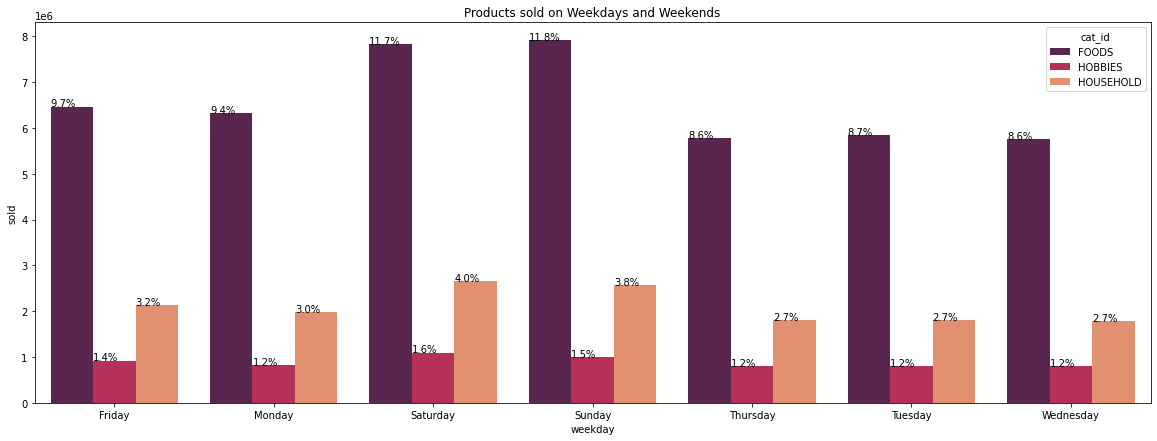

In [ ]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x = week_cat.weekday, y = week_cat.sold, hue=week_cat.cat_id, palette='rocket');
total = sum(week_cat['sold'])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))
plt.title('Products sold on Weekdays and Weekends');

Observations :-

* People buy more products on weekends than on weekdays, sale of all item categories on Saturday and Sunday is more.

* The FOODS category items are sold most Everyday.

* The HOBBIES and HOUSEHOLD category items are sold most on Saturday.

In [ ]:
# Total number of items sold in each store for each category
store_cat = df.groupby(['store_id','cat_id'], as_index=False).sum().dropna()

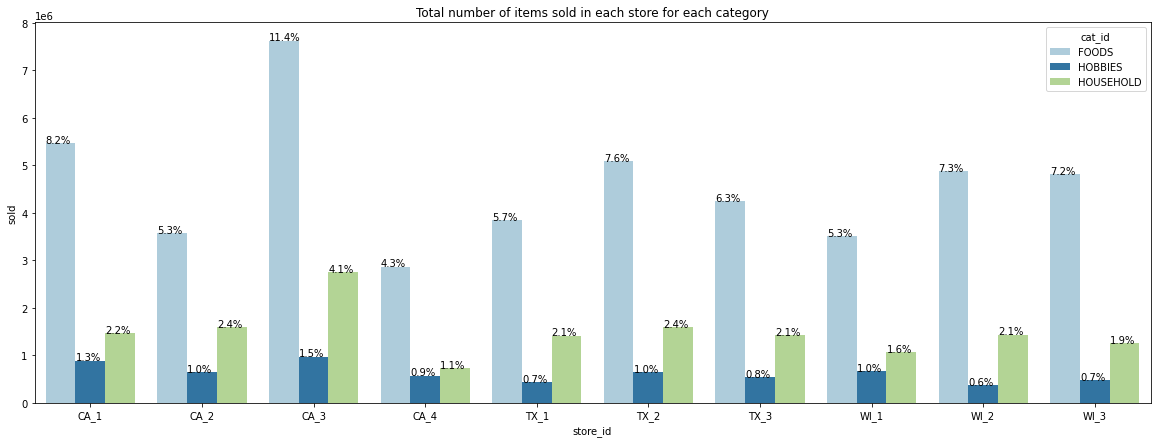

In [ ]:
plt.figure(figsize=(20,7))
ax = sns.barplot(x = store_cat.store_id, y = store_cat.sold, hue=store_cat.cat_id, palette='Paired');
total = sum(store_cat['sold'])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))
plt.title('Total number of items sold in each store for each category');

Observations :-

* CA_3 sold the most FOODS and HOUSEHOLD category items.

* CA_3 sold HOOBIES category items more than CA_1 but the difference is very less.

* Foods are the most sold items in all the stores

* The difference in number of items sold in HOBBIES category accross all the stores is very less as compared to FOODS and HOUSEHOLD categories.

In [ ]:
# Total number of items sold in each state for each category
state_cat = df.groupby(['state_id','cat_id'], as_index=False).sum().dropna()

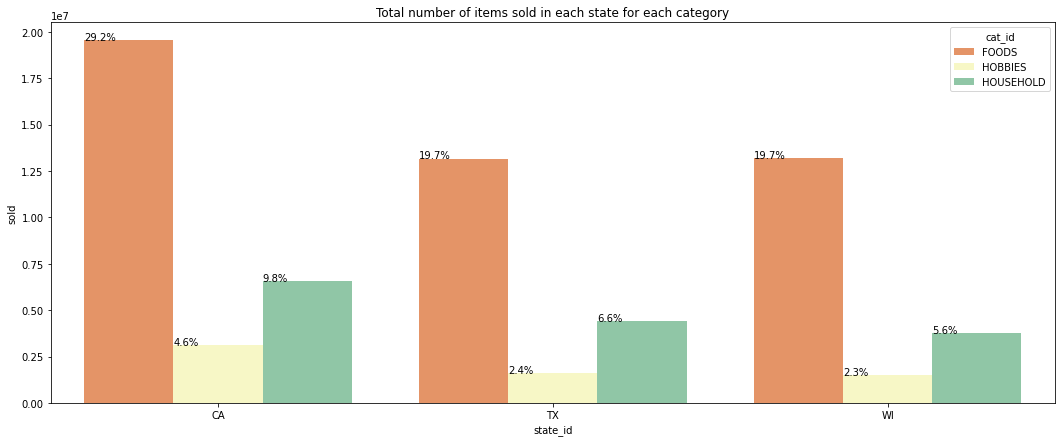

In [ ]:
plt.figure(figsize=(18,7))
ax = sns.barplot(x = state_cat.state_id, y = state_cat.sold, hue=state_cat.cat_id, palette='Spectral');
total = sum(state_cat['sold'])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))
plt.title('Total number of items sold in each state for each category');

Observations :-

* CA sold most items in all the categories.

* CA sold almost double the items in HOBBIES category as compared to TX and WI.

* TX and WI sold almost same number of items in FOODS category.

* TX sold more items than WI in HOUSEHOLD category.

In [ ]:
# Total number of products sold in events in 2016
df_2016 = df.loc[df['year'] == 2016]
event_cat = df_2016.groupby(['date','event_type_1','event_name_1','cat_id'], as_index=False)['sold'].sum()
event_cat.dropna(inplace=True)
event_cat.head()

,date,event_type_1,event_name_1,cat_id,sold
0,2016-01-01,National,NewYear,FOODS,21078
1,2016-01-01,National,NewYear,HOBBIES,3182
2,2016-01-01,National,NewYear,HOUSEHOLD,8391
3,2016-01-02,0,0,FOODS,27822
4,2016-01-02,0,0,HOBBIES,4951


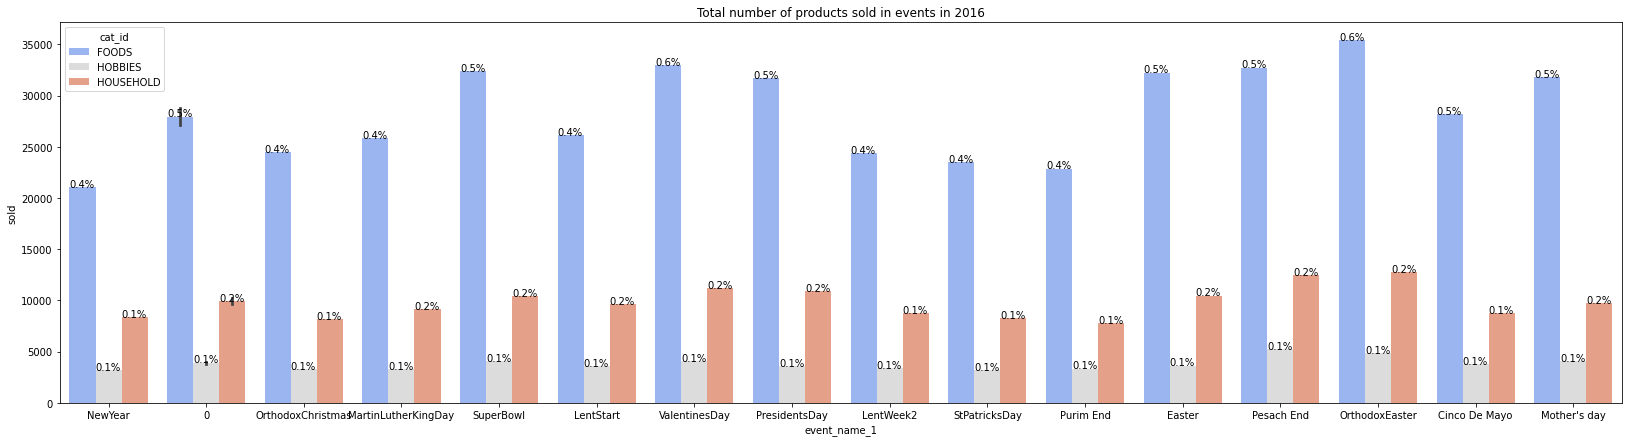

In [ ]:
plt.figure(figsize=(28,7))
ax = sns.barplot(x=event_cat.event_name_1, y=event_cat.sold, hue=event_cat.cat_id, palette='coolwarm');
total = sum(event_cat['sold'])
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x(), p.get_height()))
plt.title('Total number of products sold in events in 2016');

Observations :-

* Most of the FOODS and HOUSEHOLD category items were sold on Orthodox Easter day in 2016.

* On SuperBowl , Valentine's Day, President's Day, Easter ,Pesach End, Orthodox Easter and Mother's Day more than 30000 FOODS category items were sold in 2016.

In [ ]:
df

,store_id,cat_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1,FOODS,CA,d_1,3239,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
1,CA_1,HOBBIES,CA,d_1,556,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
2,CA_1,HOUSEHOLD,CA,d_1,542,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
3,CA_2,FOODS,CA,d_1,2193,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
4,CA_2,HOBBIES,CA,d_1,538,2011-01-29,11101,Saturday,1,1,2011,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58225,WI_2,HOBBIES,WI,d_1941,281,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0
58226,WI_2,HOUSEHOLD,WI,d_1941,1230,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0
58227,WI_3,FOODS,WI,d_1941,3484,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0
58228,WI_3,HOBBIES,WI,d_1941,342,2016-05-22,11617,Sunday,2,5,2016,0,0,0,0,0,0,0


In [ ]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [ ]:
sell_prices.groupby(['item_id']).mean()

,wm_yr_wk,sell_price
item_id,,
FOODS_1_001,11347.867684,2.166623
FOODS_1_002,11347.867684,8.933913
FOODS_1_003,11347.780142,2.975184
FOODS_1_004,11402.137778,1.848631
FOODS_1_005,11348.041889,3.329372
...,...,...
HOUSEHOLD_2_512,11348.303838,3.969964
HOUSEHOLD_2_513,11456.061200,2.780000
HOUSEHOLD_2_514,11348.042599,18.797089


In [ ]:
state_store_cal

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,0,0,0,0,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
2011-02-01,11101,Tuesday,4,2,2011,d_4,0,0,0,0,1,1,0,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
2011-02-02,11101,Wednesday,5,2,2011,d_5,0,0,0,0,1,0,1,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,Wednesday,5,5,2016,d_1937,0,0,0,0,0,0,0,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268
2016-05-19,11616,Thursday,6,5,2016,d_1938,0,0,0,0,0,0,0,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398
2016-05-20,11616,Friday,7,5,2016,d_1939,0,0,0,0,0,0,0,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126


In [ ]:
# Decomposing the series of CA state sale count
from statsmodels.tsa.seasonal import seasonal_decompose
series = state_store_cal.CA
result = seasonal_decompose(series, freq=100, model='additive')

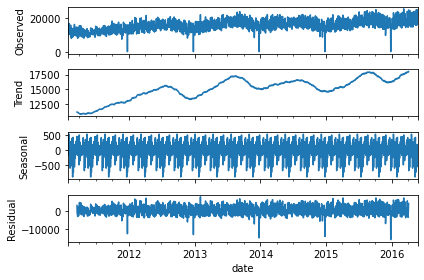

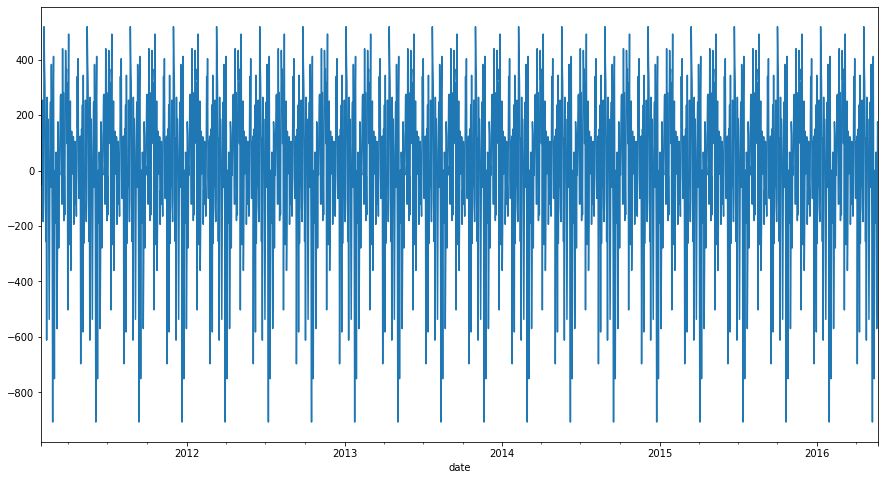

In [ ]:
result.plot()
plt.show()

result.seasonal.plot(figsize=(15,8))


* Here we can observe that there is high fluctuations(high seasonality) in the series (which is CA sales)

#-------------------------------------------------------------------------------------------------------------------------------------------

Given that multiple meaningful hierarchies can be constructed by the M5 data as shown in the below table, i have chosen aggregation level on State(2nd Level highlighted in the table) to work on which it includes total product sales of all three States i.e. CA, TX, WI in United States country


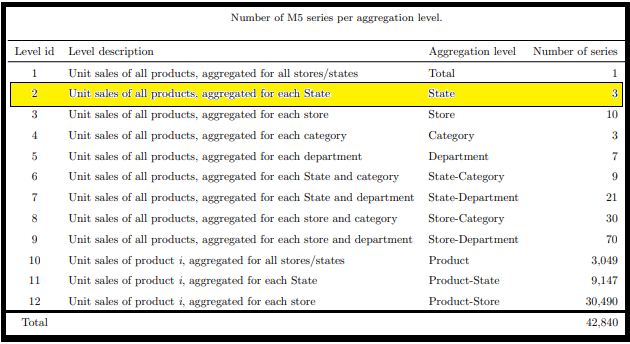

### Train-Test Split
### The sales of the first 1552 days (80 % of the total data) are used as the training sample, while the remaining 389 days (20 % of the total data) are used as the testing sample

In [ ]:
# Train-Test Split
split_point = int(0.8*len(state_store_cal))
print (state_store_cal)
train = state_store_cal[0:split_point]
test = state_store_cal[split_point:]

            wm_yr_wk    weekday  wday  month  ...  TX_3  WI_1  WI_2  WI_3
date                                          ...                        
2011-01-29     11101   Saturday     1      1  ...  3030  2704  2256  4038
2011-01-30     11101     Sunday     2      1  ...  3006  2194  1922  4198
2011-01-31     11101     Monday     3      1  ...  2225  1562  2018  3317
2011-02-01     11101    Tuesday     4      2  ...  2169  1251  2522  3211
2011-02-02     11101  Wednesday     5      2  ...  1726     2  1175  2132
...              ...        ...   ...    ...  ...   ...   ...   ...   ...
2016-05-18     11616  Wednesday     5      5  ...  3710  3242  4533  3268
2016-05-19     11616   Thursday     6      5  ...  3288  3478  4628  3398
2016-05-20     11616     Friday     7      5  ...  4390  3813  4880  4126
2016-05-21     11617   Saturday     1      5  ...  4712  5002  5213  4519
2016-05-22     11617     Sunday     2      5  ...  4974  5054  5068  4757

[1941 rows x 26 columns]


In [ ]:
train

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0,14195,9438,8998,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0,13805,9630,8314,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,0,0,0,0,10108,6778,6897,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
2011-02-01,11101,Tuesday,4,2,2011,d_4,0,0,0,0,1,1,0,11047,7381,6984,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
2011-02-02,11101,Wednesday,5,2,2011,d_5,0,0,0,0,1,0,1,9925,5912,3309,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-25,11513,Saturday,1,4,2015,d_1548,0,0,0,0,0,0,0,19071,12049,12478,6019,3230,7251,2571,3474,4421,4154,4927,4107,3444
2015-04-26,11513,Sunday,2,4,2015,d_1549,0,0,0,0,0,0,0,19426,12387,11593,5815,2947,7890,2774,3804,4417,4166,4168,3958,3467
2015-04-27,11513,Monday,3,4,2015,d_1550,0,0,0,0,0,0,0,14773,9873,8798,3995,2257,5909,2612,2779,3413,3681,2799,3479,2520


In [ ]:
test

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-04-30,11513,Thursday,6,4,2015,d_1553,0,0,0,0,0,0,0,12985,8967,8601,3466,2045,5114,2360,2404,3197,3366,3002,3309,2290
2015-05-01,11513,Friday,7,5,2015,d_1554,0,0,0,0,1,1,0,17168,12238,11570,5121,2773,6637,2637,3295,4032,4911,3933,4328,3309
2015-05-02,11514,Saturday,1,5,2015,d_1555,0,0,0,0,1,0,1,19497,13252,14303,5801,3068,7586,3042,4086,4599,4567,4624,5341,4338
2015-05-03,11514,Sunday,2,5,2015,d_1556,0,0,0,0,1,1,1,20394,13859,14849,6524,3347,7757,2766,4233,4692,4934,4412,5661,4776
2015-05-04,11514,Monday,3,5,2015,d_1557,0,0,0,0,1,0,0,17031,10376,10762,4794,2094,7345,2798,2925,3529,3922,3278,4277,3207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,Wednesday,5,5,2016,d_1937,0,0,0,0,0,0,0,15678,10375,11043,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268
2016-05-19,11616,Thursday,6,5,2016,d_1938,0,0,0,0,0,0,0,16297,9162,11504,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398
2016-05-20,11616,Friday,7,5,2016,d_1939,0,0,0,0,0,0,0,17430,12303,12819,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126


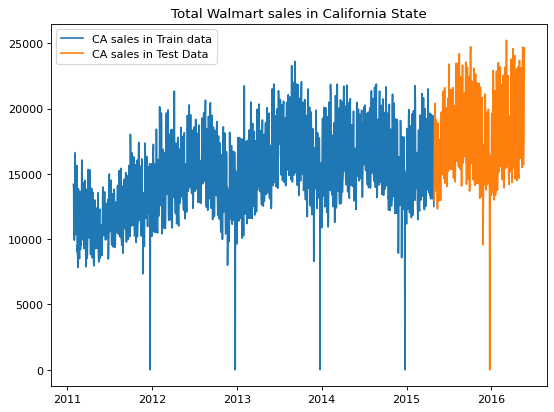

In [ ]:
# Visualize the train test split in the data using matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(train.CA, label="CA sales in Train data")
plt.plot(test.CA, label="CA sales in Test Data")
plt.legend()
plt.title('Total Walmart sales in California State')
plt.show()

In [ ]:
train[(train.CA<50) | (train.WI<50) | (train.TX<50)] 

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,0,0,0,0,0,8,2,3,0,7,1,0,0,0,2,0,3,0
2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,0,0,0,0,0,6,2,3,0,2,4,0,0,0,2,0,3,0
2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,0,0,0,0,0,5,13,2,0,2,3,0,1,11,1,1,0,1
2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,0,0,0,0,0,6,13,1,0,6,0,0,0,7,6,0,0,1


In [ ]:
test[(test.CA<50) | (test.WI<50) | (test.TX<50)]

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,0,0,0,0,0,6,4,4,0,2,4,0,1,0,3,2,1,1


* Above dataframes shows that every year on 25th Dec, all the three states sales are less(<50), this also corresponds to seasonality in this dataset

-------------------------------------------------------------------------------------------------------------

Checking the stationarity of the data using statistical test on train data

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
X = train.CA
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.258700
p-value: 0.185634
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


* Test statistic is greater than the critical values, we fail to reject the null hypothesis (which means the series is not stationary).

In [ ]:
X = train.CA
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 3.790415
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


* We reject the null hypothesis that the time series has a unit root. What this means is that the time series is non-stationary.

Autocorrelation and Partial autocorrelation

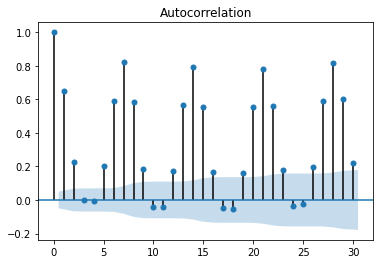

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(X, lags=30)

* There is a periodic increase and decrease in the sales which corresponds to seasonality in the data

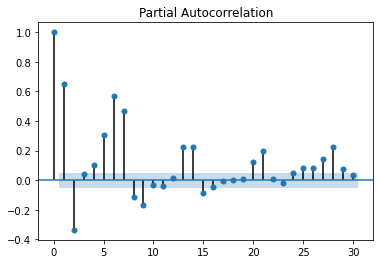

In [ ]:
pacf = plot_pacf(X, lags=30)

# Model building and Validation
### Start with Naive methods

In [ ]:
# Prediction is mean of historical data of CA walmart salez
pred = train.CA.mean()
# For single train-test split the prediction will be same for all the test points
prediction = [pred]*len(test)
# Add predictions as a column in test
test['Naive_pred'] = prediction

In [ ]:
# Calculating the RMSE between actual values and prediction
from sklearn import metrics
from math import sqrt

error = sqrt(metrics.mean_squared_error(test.CA,test.Naive_pred))
print (error)

4142.659516684003


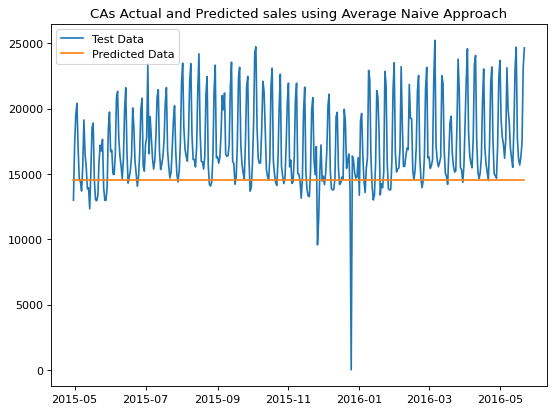

In [ ]:
# Visualize the test data and naive average method predictions using matplotlib

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.Naive_pred, label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using Average Naive Approach')
plt.show()

# -----------------------------------------------------------------------------------------------------------------

In [ ]:
# Walk-forward validation for average naive method
import numpy as np

pred_wf = []
X= train.CA.values

# For every element in test, make a prediction, append the test point to training set and loop ahead
for i in test.CA:
  pred =  X.mean()
  pred_wf.append(pred)
  X = np.append(X, i)
  # print ("Length of historical data: ", len(X), pred, len(test))

In [ ]:
# Adding the walk forward prediction as a column in test data
test['Naive_pred_wf'] = pred_wf

In [ ]:
# Calculating RMSE for walk forward validation using average naive method
error = sqrt(metrics.mean_squared_error(test.CA,test.Naive_pred_wf))
print (error)

3961.3992938884016


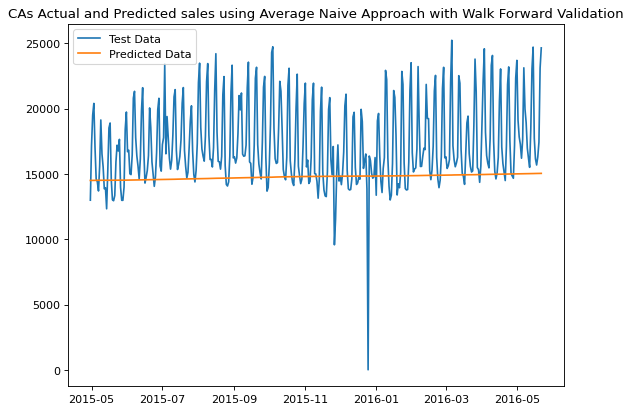

In [ ]:
# Plot the actual and predicted values
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.Naive_pred_wf, label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using Average Naive Approach with Walk Forward Validation')
plt.show()

# -----------------------------------------------------------------------------------------------------------------

In [ ]:
# Prediction is the last observed value of historical data of COVID-19 deaths using walk forward validation
pred_nm_wf = []
X = train.CA.values

# For every element in test, make a prediction, append the test point to training set and loop ahead
for i in test.CA:
  pred =  X[-1]
  pred_nm_wf.append(pred)
  X = np.append(X, i)

In [ ]:
# Add the walk forward prediction as a column in test data
test['pred_nm_wf'] = pred_nm_wf

In [ ]:
# Calculate RMSE for walk forward validation using naive method
error = sqrt(metrics.mean_squared_error(test.CA,test.pred_nm_wf))
print (error)

3148.705770356709


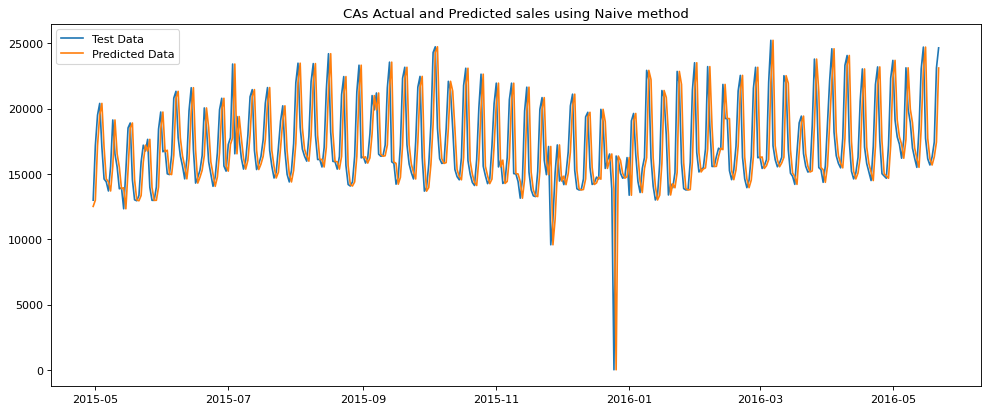

In [ ]:
# Visualize the test data and naive method predictions using matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(15, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.pred_nm_wf, label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using Naive method')
plt.show()

* Though seem to have actual and predicted value very close, but it is just be a copy of previous value and wont look like a very good model. Hence we use actual statistical models like ARIMA and Exponential Smoothing

In [ ]:
#differencing and checking again for seasonality
X = train.CA.diff(periods=7).dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.577035
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


* So after first order difference our time series has become stationary

In [ ]:
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.045835
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


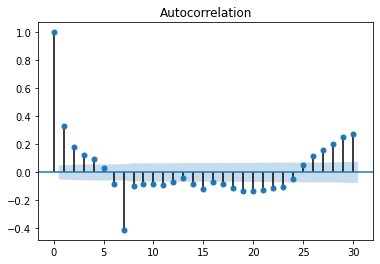

In [ ]:
# Autocorrelation
acf = plot_acf(X, lags=30)

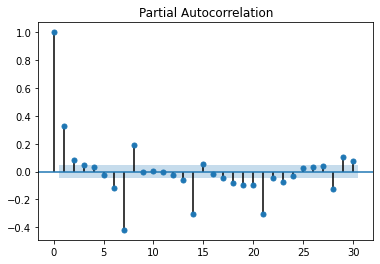

In [ ]:
# Partial auto correlation
pacf = plot_pacf(X, lags=30)

##ARIMA

A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA stands for AutoRegressive Integrated Moving Average.

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.CA, order=(7,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

ModuleNotFoundError: ignored

In [ ]:
# Perform out-of-sample predictions for the entire test data
forecast = model_fit.predict(start=train.CA.shape[0], end=train.CA.shape[0]+len(test)-1)
test['Vannila_arima'] = forecast

In [ ]:
# Calculate the error between actual and predicted values
error = sqrt(metrics.mean_squared_error(test.CA,forecast))
print (error)

In [ ]:
# Plot the actual and predicted values for COVID-19 related fatalities
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.Vannila_arima, label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using ARIMA method')
plt.show()

* Vanilla Arima not performing well in the test data as ARIMA uses recursive technique to make multiple predictions which leads to error accumulation.
A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle.
---------------------------------------------------------------------------------------------------------

Seasonal ARIMA: This is an extension of ARIMA model to deal with seasonal data. It divides the data into seasonal and non-seasonal components and models them in a similar fashion.

In [ ]:
# Fit the SARIMA model as the series has high seasonality
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train.CA, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

In [ ]:
# Perform out-of-sample predictions for the entire test data
forecast = model_fit.predict(start=train.CA.shape[0], end=train.CA.shape[0]+len(test)-1)
test['Vannila_sarimax'] = forecast

In [ ]:
# Calculate the error between actual and predicted values
error = sqrt(metrics.mean_squared_error(test.CA,forecast))
print (error)

In [ ]:
# Plot the actual and predicted values for COVID-19 related fatalities
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.Vannila_sarimax, label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using SARIMA method')
plt.show()

* We can see for very large prediction horizon the model is not able to keep on predicting and is just giving an average value

-----------------------------------------------------------------------------------------------------------------------------------

#### AUTOARIMA WITH SARIMA

In [ ]:
!pip install pmdarima

* Now, we will use auto arima, where given a range of values, the model parameters are configured for us based on lower AIC and BIC values.

In [ ]:
from pmdarima.arima import auto_arima
sarima_model = auto_arima(train['CA'], start_p=0, start_q=0,
                          max_p=7, max_q=5,
                          seasonal=True, m=7,
                          d=1, trace=True,random_state=12345,
                          out_of_sample_size=28,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)
sarima_model.summary()

* As it throwed best parameters, we will use those to make the mdoel.
* Best model:  ARIMA(1,1,0) (1,0,1)[7] intercept

In [ ]:
# Fit the model on train data and forecast the next set of values according to length of the test data
model = SARIMAX(train.CA, order=(1,1,0), seasonal_order=(1,0,1,7))
model_fit = model.fit()
forecast = model_fit.predict(start=train.CA.shape[0], end=train.CA.shape[0]+len(test)-1)

test['Auto_sarima'] = forecast

In [ ]:
# Calculate the error between actual and predicted values
from sklearn import metrics
from math import sqrt

error = sqrt(metrics.mean_squared_error(test.CA,forecast))
print (error)

In [ ]:
# Plot actual and predicted data
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.AutoArima_sarima, 'r--', label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using Auto ARIMA')
plt.show()

* ARIMA uses recursive technique to make multiple predictions which leads to error accumulation, which is why we can see the prediction moving away from the original value for the predictions.

#### AUTO ARIMA WITH EXOGENOUS VARIABLE

In [ ]:
from scipy.stats import pearsonr
#Checking the correlation between CA sales and WI sales
corr, p = pearsonr(train.CA, train.TX)
print(corr)
plt.plot(train.CA, train.TX)

* As you can observe TX has high positive correlatin with CA series, hence we will use that as exogenous variable in modelling
* We can use any other variable as exogenous which impacts CA sales here

In [ ]:
# model_name='SARIMAX'
sarimax_model = auto_arima(train['CA'], start_p=0, start_q=0, d=1,
                          max_p=10, max_q=10, m=7,
                          seasonal=True, stationary=False,
                          exogenous = train[['TX']].values,
                          information_criterion='aic', alpha=0.05, trace=True)
sarimax_model.summary()

In [ ]:
# Fit the model on train data and forecast the next set of values according to length of the test data
sarimax_model.fit(train.CA)
forecast = sarimax_model.predict(n_periods=389,exog=test.TX)

test['AutoArima_sarimax'] = forecast

In [ ]:
error = sqrt(metrics.mean_squared_error(test.CA,forecast))
print (error)

In [ ]:
# Plot actual and predicted data
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.AutoArima_sarimax, 'r--', label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using Auto SARIMA')
plt.show()

Where i observed that while performing auto arima, below are the values which gives lower AIC. We use these values to fit the SARIMAX

Best model:  ARIMA(1,1,1)(1,0,1)[7] intercept


In [ ]:
 # Fit the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train.CA, order=(1,1,1), seasonal_order=(1,0,1,7), exog = train.TX)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

In [ ]:
forecast = model_fit.predict(start=train.CA.shape[0], end=train.CA.shape[0]+len(test)-1, exog = np.asarray(test.TX,dtype=float).reshape(389,1))

test['SARIMAX_exo'] = forecast

In [ ]:
# Calculate the error between actual and predicted values
error = sqrt(metrics.mean_squared_error(test.CA,forecast))
print (error)

In [ ]:
# Plot actual and predicted data
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.SARIMAX_exo, label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted sales using SARIMAX with Exogenous variable')
plt.show()

* We can see that TX sales having positive correlation with CA state product sales, hence we got lower loss and good predictions by using the exogenous varaible

In [ ]:
test

* Till now, we have implemented various models like naive, naive with walk forward validation, Arima, SARIMAX, AutoArima with Sarima and SarimaX


## EXPONENTIAL SMOOTHING
Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

In [ ]:
# As our series is highly seasonal, we use Triple Exponential smoothing..it explicitly adds support for seasonality to the univariate time series.
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train.CA.values, seasonal='additive', seasonal_periods= 7)
model_fit = model.fit()

In [ ]:
# Predict for future values using exponential smoothing parameters
predictions_ = model_fit.predict(len(train),len(train)+len(test)-1)

In [ ]:
# Add a column in test with prediction by DES model
test['pred_ES'] = predictions_
error = sqrt(metrics.mean_squared_error(test.CA,test.pred_ES))
print (error)
# Plot actual and predicted data
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.pred_ES, 'r--', label="Predicted Data")
plt.legend()
plt.title('CA Actual and Predicted Sales using Triple Exponential Smoothing')
plt.show()

Performing Triple Exponential Smoothing with Walk Forward validation

In [ ]:
# Perform out-of-sample predictions using walk forward validation
pred_WF = []
X = train.CA.values

# For every element in test, make a prediction, append the test point to training set and loop ahead
for index,i in test.iterrows():
  model_fit = ExponentialSmoothing(X, seasonal='additive', seasonal_periods= 7).fit()
  pred =  model_fit.predict()
  pred_WF.append(pred[0])
  X = np.append(X, i.CA)

In [ ]:
# Add a column in test with prediction by SARIMA model
test['pred_ES_WF'] = pred_WF
error = sqrt(metrics.mean_squared_error(test.CA,test.pred_ES_WF))
print (error)
# Plot actual and predicted data
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(test.CA, label="Test Data")
plt.plot(test.pred_ES_WF, 'r--', label="Predicted Data")
plt.legend()
plt.title('CA Actual and Predicted Sales using ES model and walk forward validation')
plt.show()

* Exponential Smoothing giving better results with walk forward validation where the model fitted well and took less time also.

* We can conclude that where all the models performs poorly if the prediction horizon is bigger, as walk forward methodology involves moving along the time series one-time step at a time and fitting a the model and predicting the series of observations one at a time. 
This has the benefit of providing a much more robust estimation thus we could see the results above and earlier plots with different models
#----------------------------------------------------------------------------------------------------------------------------------------

So far we implemented statistical models for time-series analysis and forecasting, we used highly interpretable tests, plots and models to understand and model various dimensions of the data. These work well on univariate time series but may not with multi-variate series of prediction.

#### Enter Multilayer Perceptron or often called as Neural Networks
Its a Artificial Neural Network consists of atleast 3 layers that are, Input layer, Hidden layer, Output layer. Its non-linear model where it can fit any funtions in the mathematical space. Uses Backpropogation technique to train and optimize the network.

Let's try to fit the neural network on our M5 dataset and try to predict multiple time series such as CA, TX and WI together.

In [ ]:
# Converting time-series sequence to samples
l = ['t-1','t-2','t-3']
samples = pd.DataFrame(train.CA)
for i in range (len(l)):
  samples[l[i]] = train.CA.shift(i+1)
print (samples)
samples = samples.dropna()
samples

In [ ]:
# Converting to independent and dependent variables
import numpy as np
X = np.array(samples[['t-1','t-2','t-3']]) # Independent Variables
y = np.array(samples['CA'])                # Dependent/Target Variable
X, y

In [ ]:
# Defining the model architecture
from keras.models import Sequential
from keras.layers import Dense

# Set input nodes equal to input dimension
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=len(l)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fitting the model on train samples
model.fit(X, y, epochs=100, verbose=1)

In [ ]:
# Converting time-series sequence to samples
l = ['t-1','t-2','t-3']
samples = pd.DataFrame(test.CA)
for i in range (len(l)):
  samples[l[i]] = test.CA.shift(i+1)
print (samples)
samples = samples.dropna()
samples

In [ ]:
# Converting to independent and dependent variables for test data as well to predict and check the loss
import numpy as np
test_X = np.array(samples[['t-1','t-2','t-3']]) # Independent Variables
test_y = np.array(samples['CA'])                # Dependent/Target Variable

In [ ]:
samples['Predicted']= model.predict(test_X)

In [ ]:
# Calculate the test error between the test data and MLP predictions
from sklearn import metrics
from math import sqrt
error = sqrt(metrics.mean_squared_error(samples.CA,samples.Predicted))
print (error)

In [ ]:
# Visualize the test data and MLP predictions using matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.plot(samples.CA, label="Test Data")
plt.plot(samples.Predicted, '--', label="Predicted Data")
plt.legend()
plt.title('CAs Actual and Predicted Sales using Multilayer Perceptron')
plt.show()

### Adding more variables

Multiple Input Series - As exogenous variables - where you use external variable to help you make the prediction

Multiple Parllel Series - Multivariate Predictions - where you predict multiple variables / multiple time-series simultaneously.

While using neural networks, the way you create samples is the key to solving the time-series problem with one or more variables.

Multiple Input Series

In [ ]:
# Converting train sequence with multiple variables into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
		# Find the end of this pattern
    end_ix = i + n_steps
		# Check if we are beyond the dataset
    if end_ix > len(sequences):
     break
		# Gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    print (seq_x, seq_y)
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
train['CA_1'] = train.CA[500].shift(1)
train = train.dropna()

sequences = np.array(train[['CA', 'CA_1', 'TX']])
print(sequences)
X, y = split_sequences(sequences, 5)

n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fitting the model on train samples
model.fit(X, y, epochs=100, verbose=1)

In [ ]:
# Structure the test data
test['CA_1'] = test.CA.shift(1)
test = test.dropna()

test_sequences = np.array(test[['CA', 'CA_1', 'TX']])
test_X, test_y = split_sequences(test_sequences, 5)

n_input = test_X.shape[1] * test_X.shape[2]
test_X = test_X.reshape((test_X.shape[0], n_input))

In [ ]:
# Make predictions for multiple input series
yhat = model.predict(test_X)
print(yhat)